In [37]:
# !pip3 install wordcloud

In [14]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import re
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [15]:
# Open the text file
with open("text_converter/test.txt", "r") as file:
    # Read the entire contents of the file into a string
    text = file.read()

# Split the text into sentences using the nltk sentence tokenizer
sentences = nltk.sent_tokenize(text)
print(len(sentences))
print(sentences[:10])

corpus = PlaintextCorpusReader('text_converter', '.+\.txt')
#doc = [corpus.words(f) for f in corpus.fileids()] #Take all files
doc = corpus.words('test.txt')
print(len(doc))

5388
['\n \nJustice Michael Sandel This book was produced in EPUB format by the Internet Archive.', 'The book pages were scanned and converted to EPUB format automatically.', 'This process relies on optical character recognition, and is somewhat susceptible to errors.', 'The book may not offer the correct reading sequence, and there may be weird characters, non-words, and incorrect guesses at structure.', 'Some page numbers and headers or footers may remain from the scanned page.', 'The process which identifies images might have found stray marks on the page which are not actually images from the book.', "The hidden page numbering which may be available to your ereader corresponds to the numbered pages in the print edition, but is not an exact match;  page numbers will increment at the same rate as the corresponding print edition, but we may have started numbering before the print book's visible page numbers.", 'The Internet Archive is working to improve the scanning process and result

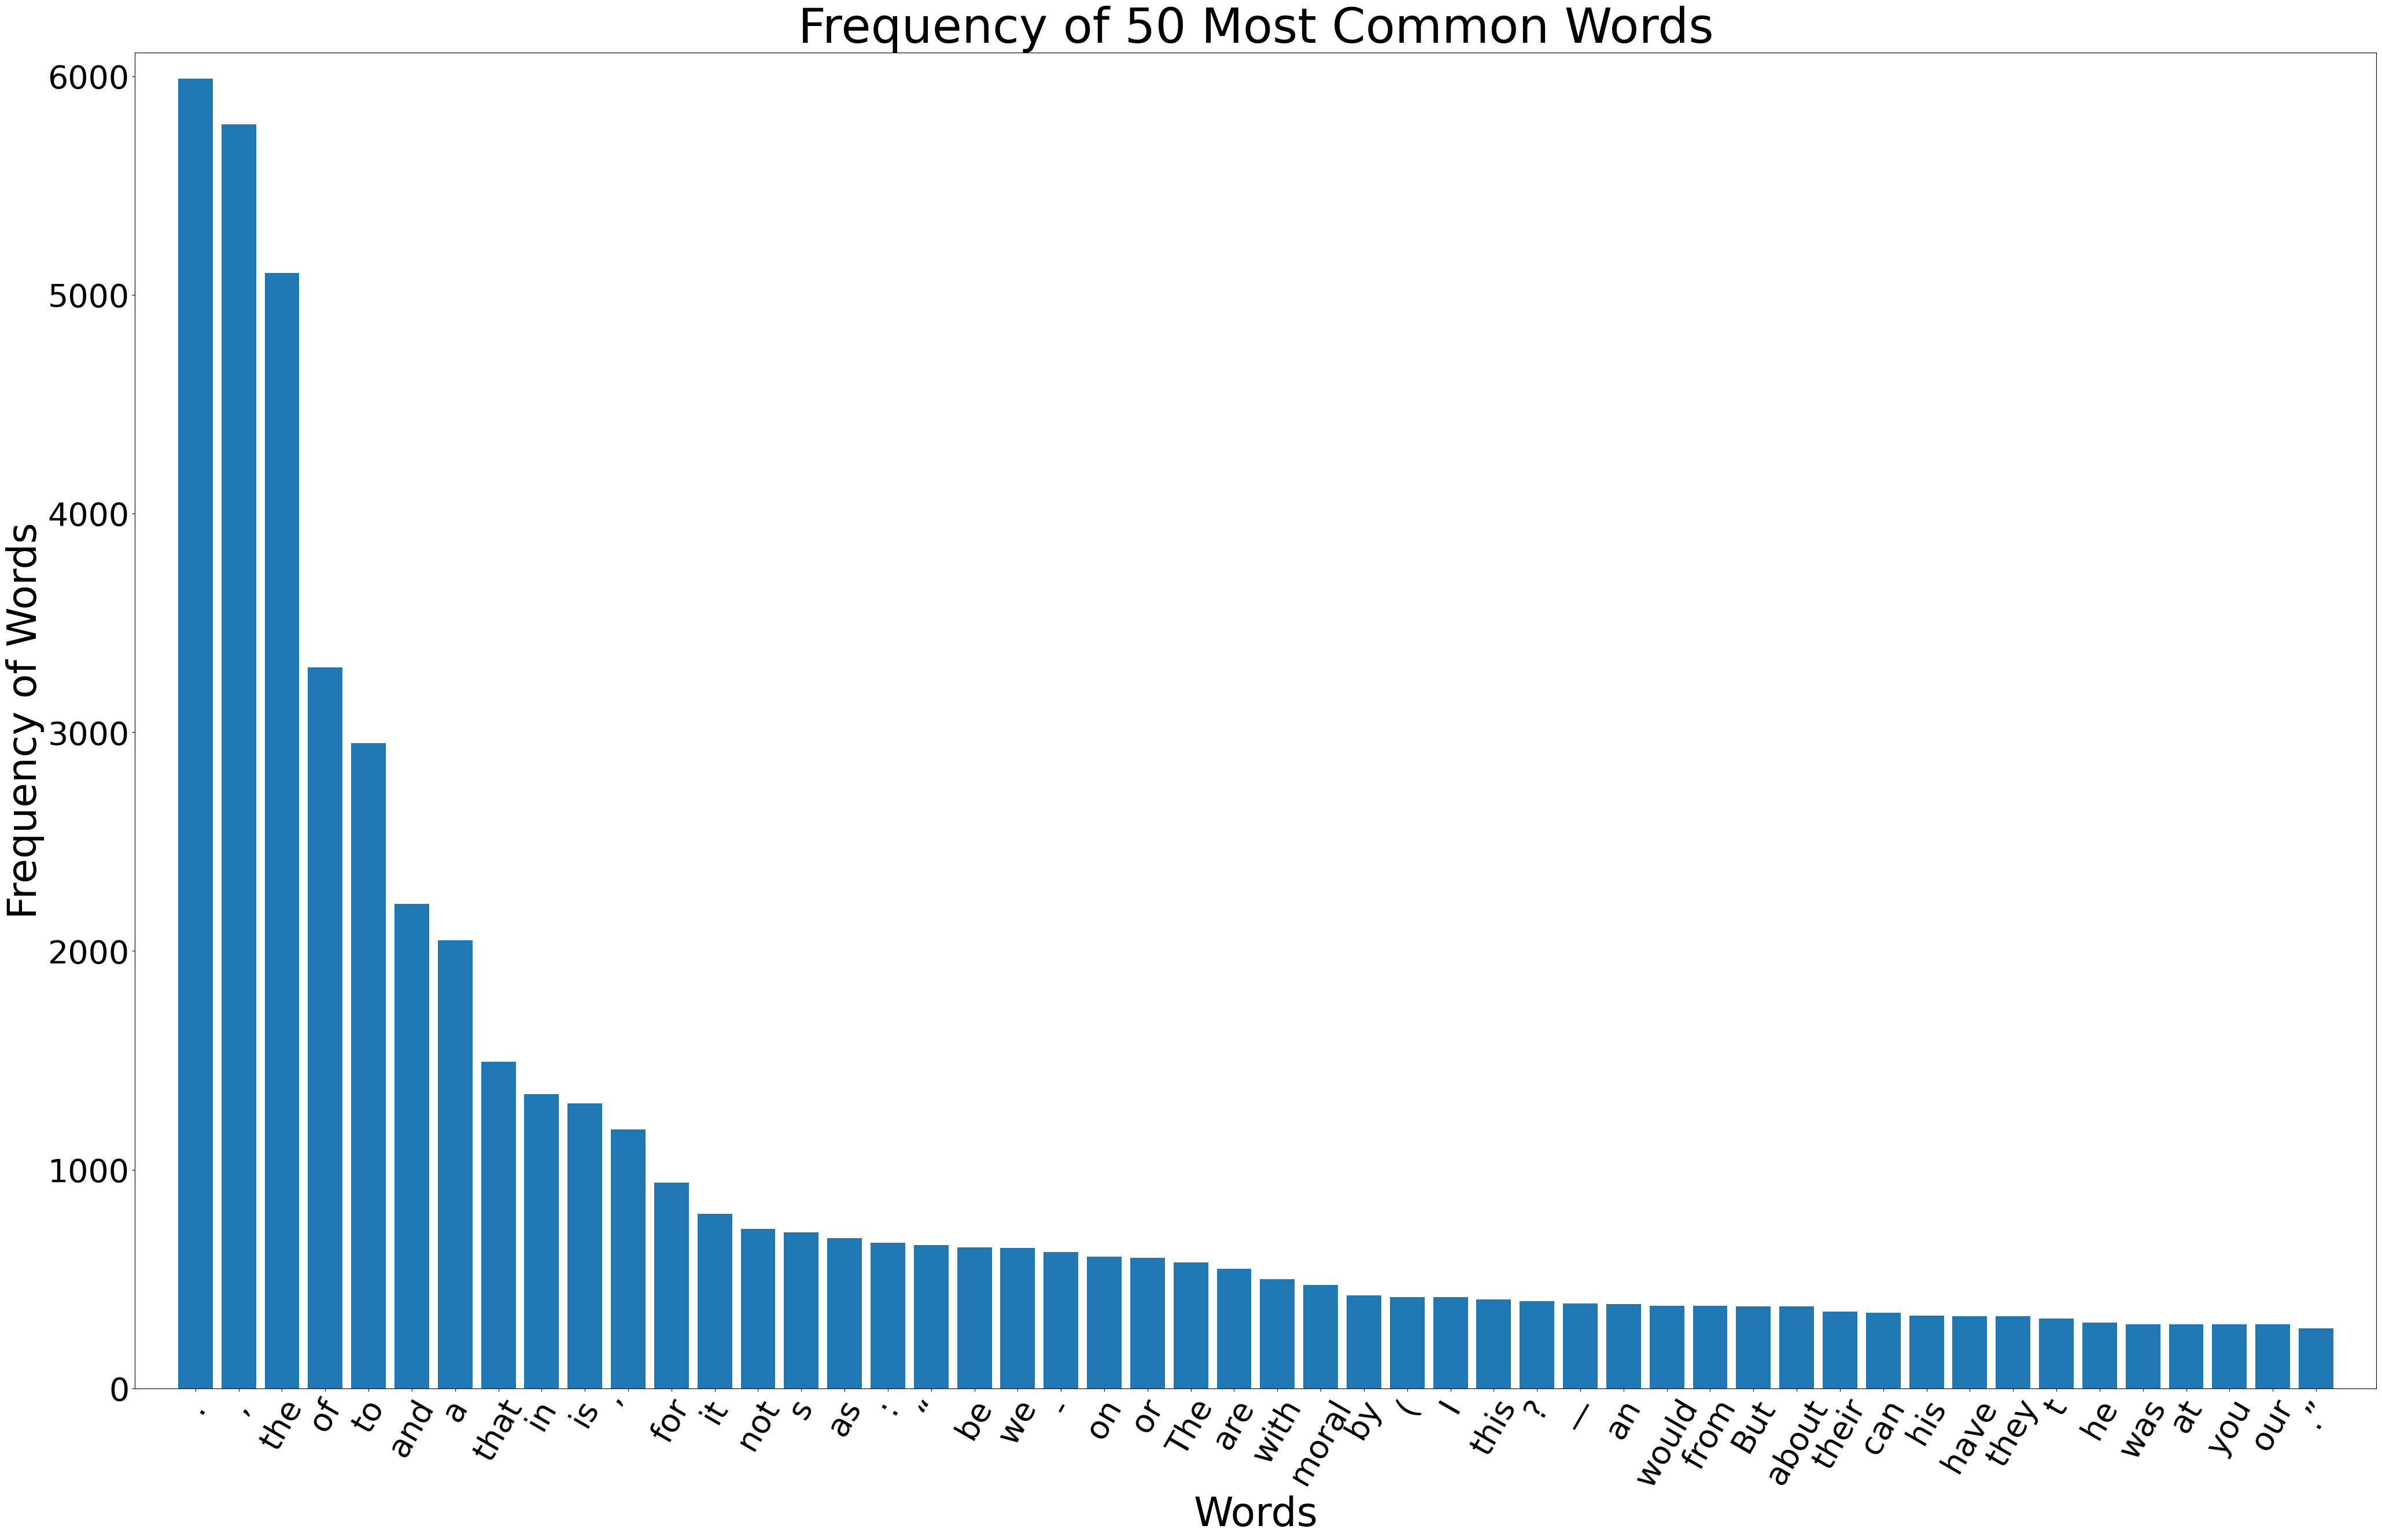

In [20]:
fdist_doc = FreqDist(doc).most_common(50)
# print(fdist_justice.most_common(20))
x, y = zip(*fdist_doc)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 50 Most Common Words', fontsize=60)
plt.show()

In [3]:
# POS + lemming for better lemming performance:
# The lemmatizer requires the correct POS tag to be accurate, 
# if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun
# https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py#L39 
wnl = WordNetLemmatizer()

justice_lemmed = list()
for sen in sentences:
    sens = list()
    for word, tag in pos_tag(word_tokenize(sen)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = wnl.lemmatize(word, wntag) if wntag else word
        sens.append(lemma)
    justice_lemmed.append(sens)

print(len(justice_lemmed))

5388


In [4]:
print(justice_lemmed[:10])

[['Justice', 'Michael', 'Sandel', 'This', 'book', 'be', 'produce', 'in', 'EPUB', 'format', 'by', 'the', 'Internet', 'Archive', '.'], ['The', 'book', 'page', 'be', 'scan', 'and', 'convert', 'to', 'EPUB', 'format', 'automatically', '.'], ['This', 'process', 'rely', 'on', 'optical', 'character', 'recognition', ',', 'and', 'be', 'somewhat', 'susceptible', 'to', 'error', '.'], ['The', 'book', 'may', 'not', 'offer', 'the', 'correct', 'reading', 'sequence', ',', 'and', 'there', 'may', 'be', 'weird', 'character', ',', 'non-words', ',', 'and', 'incorrect', 'guess', 'at', 'structure', '.'], ['Some', 'page', 'number', 'and', 'header', 'or', 'footer', 'may', 'remain', 'from', 'the', 'scanned', 'page', '.'], ['The', 'process', 'which', 'identifies', 'image', 'might', 'have', 'find', 'stray', 'mark', 'on', 'the', 'page', 'which', 'be', 'not', 'actually', 'image', 'from', 'the', 'book', '.'], ['The', 'hidden', 'page', 'number', 'which', 'may', 'be', 'available', 'to', 'your', 'ereader', 'corresponds'

In [5]:
justice_lower_words = list()

for s in justice_lemmed:
    #Lowercase
    sen = [w.lower() for w in s]
    # remove punctuations
    sentence = [w for w in sen if re.search('^[a-z0-9]+$',w)]
    # remove empty lists
    if len(sentence) > 0:
        justice_lower_words.append(sentence)
print(len(justice_lower_words))
print(justice_lower_words[:10])

5234
[['justice', 'michael', 'sandel', 'this', 'book', 'be', 'produce', 'in', 'epub', 'format', 'by', 'the', 'internet', 'archive'], ['the', 'book', 'page', 'be', 'scan', 'and', 'convert', 'to', 'epub', 'format', 'automatically'], ['this', 'process', 'rely', 'on', 'optical', 'character', 'recognition', 'and', 'be', 'somewhat', 'susceptible', 'to', 'error'], ['the', 'book', 'may', 'not', 'offer', 'the', 'correct', 'reading', 'sequence', 'and', 'there', 'may', 'be', 'weird', 'character', 'and', 'incorrect', 'guess', 'at', 'structure'], ['some', 'page', 'number', 'and', 'header', 'or', 'footer', 'may', 'remain', 'from', 'the', 'scanned', 'page'], ['the', 'process', 'which', 'identifies', 'image', 'might', 'have', 'find', 'stray', 'mark', 'on', 'the', 'page', 'which', 'be', 'not', 'actually', 'image', 'from', 'the', 'book'], ['the', 'hidden', 'page', 'number', 'which', 'may', 'be', 'available', 'to', 'your', 'ereader', 'corresponds', 'to', 'the', 'numbered', 'page', 'in', 'the', 'print', '

In [6]:
# stop words removal + stemming
stemmer = PorterStemmer()

stop_list = stopwords.words('english')
justice_stemmed = list()
for l in justice_lower_words:
    
    # lemmed = [lemmatizer.lemmatize(w) for w in sen]
    sen = [w for w in l if w not in stop_list]
    stemmed = [stemmer.stem(w) for w in sen]
    justice_stemmed.append(stemmed)
print(len(justice_stemmed))
print(justice_stemmed[:10])

5234
[['justic', 'michael', 'sandel', 'book', 'produc', 'epub', 'format', 'internet', 'archiv'], ['book', 'page', 'scan', 'convert', 'epub', 'format', 'automat'], ['process', 'reli', 'optic', 'charact', 'recognit', 'somewhat', 'suscept', 'error'], ['book', 'may', 'offer', 'correct', 'read', 'sequenc', 'may', 'weird', 'charact', 'incorrect', 'guess', 'structur'], ['page', 'number', 'header', 'footer', 'may', 'remain', 'scan', 'page'], ['process', 'identifi', 'imag', 'might', 'find', 'stray', 'mark', 'page', 'actual', 'imag', 'book'], ['hidden', 'page', 'number', 'may', 'avail', 'eread', 'correspond', 'number', 'page', 'print', 'edit', 'exact', 'match', 'page', 'number', 'increment', 'rate', 'correspond', 'print', 'edit', 'may', 'start', 'number', 'print', 'book', 'visibl', 'page', 'number'], ['internet', 'archiv', 'work', 'improv', 'scan', 'process', 'result', 'book', 'meantim', 'hope', 'book', 'use'], ['internet', 'archiv', 'found', '1996', 'build', 'internet', 'librari', 'promot', 'un

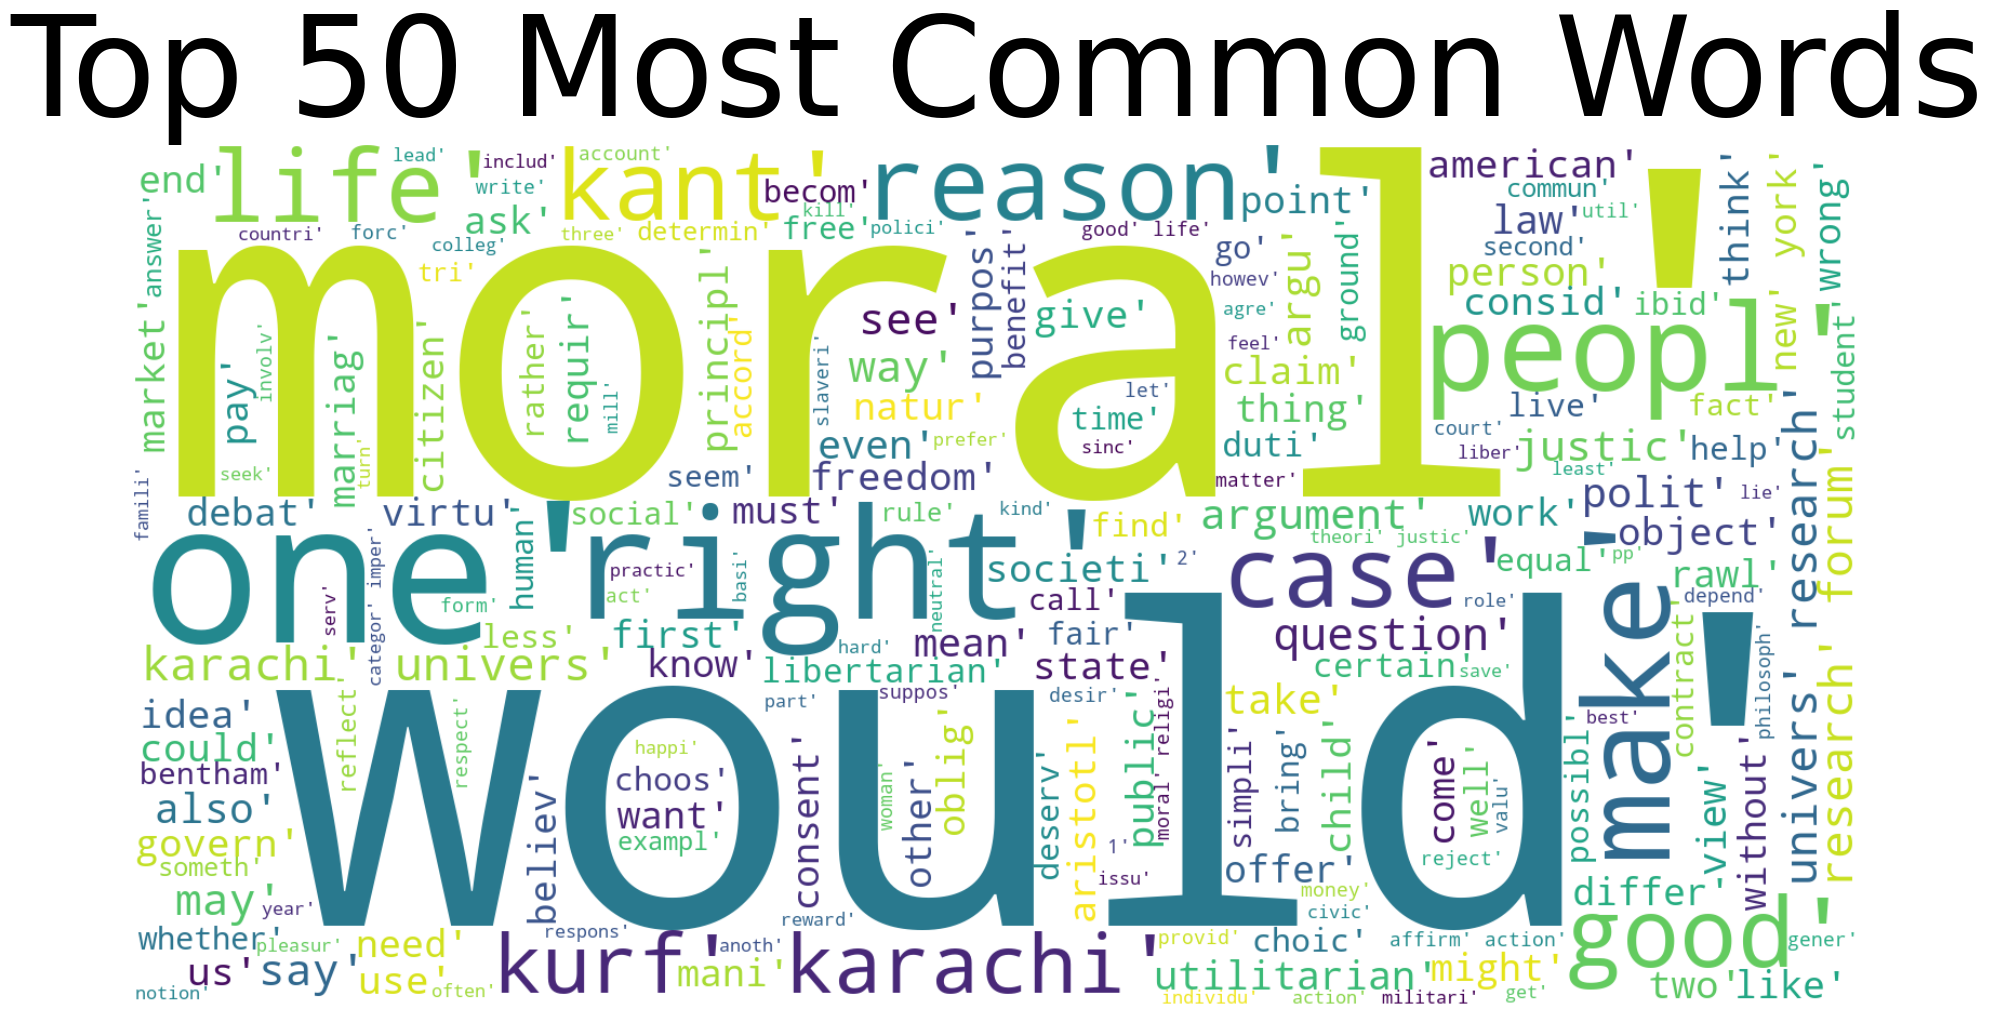

AttributeError: 'list' object has no attribute 'items'

In [21]:
# Get the top-20 most frequent words in the file. User FreqDist an most_common
temp = list()
for sen in justice_stemmed:
    for word in sen:
        temp.append(word)

fdist_justice = FreqDist(temp).most_common(50)
# print(fdist_justice.most_common(20))

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(temp))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Number of *unique* words in the file
filtered_word_freq = dict((word, freq) for word, freq in fdist_justice.items() if not word.isdigit())
print(len(filtered_word_freq))

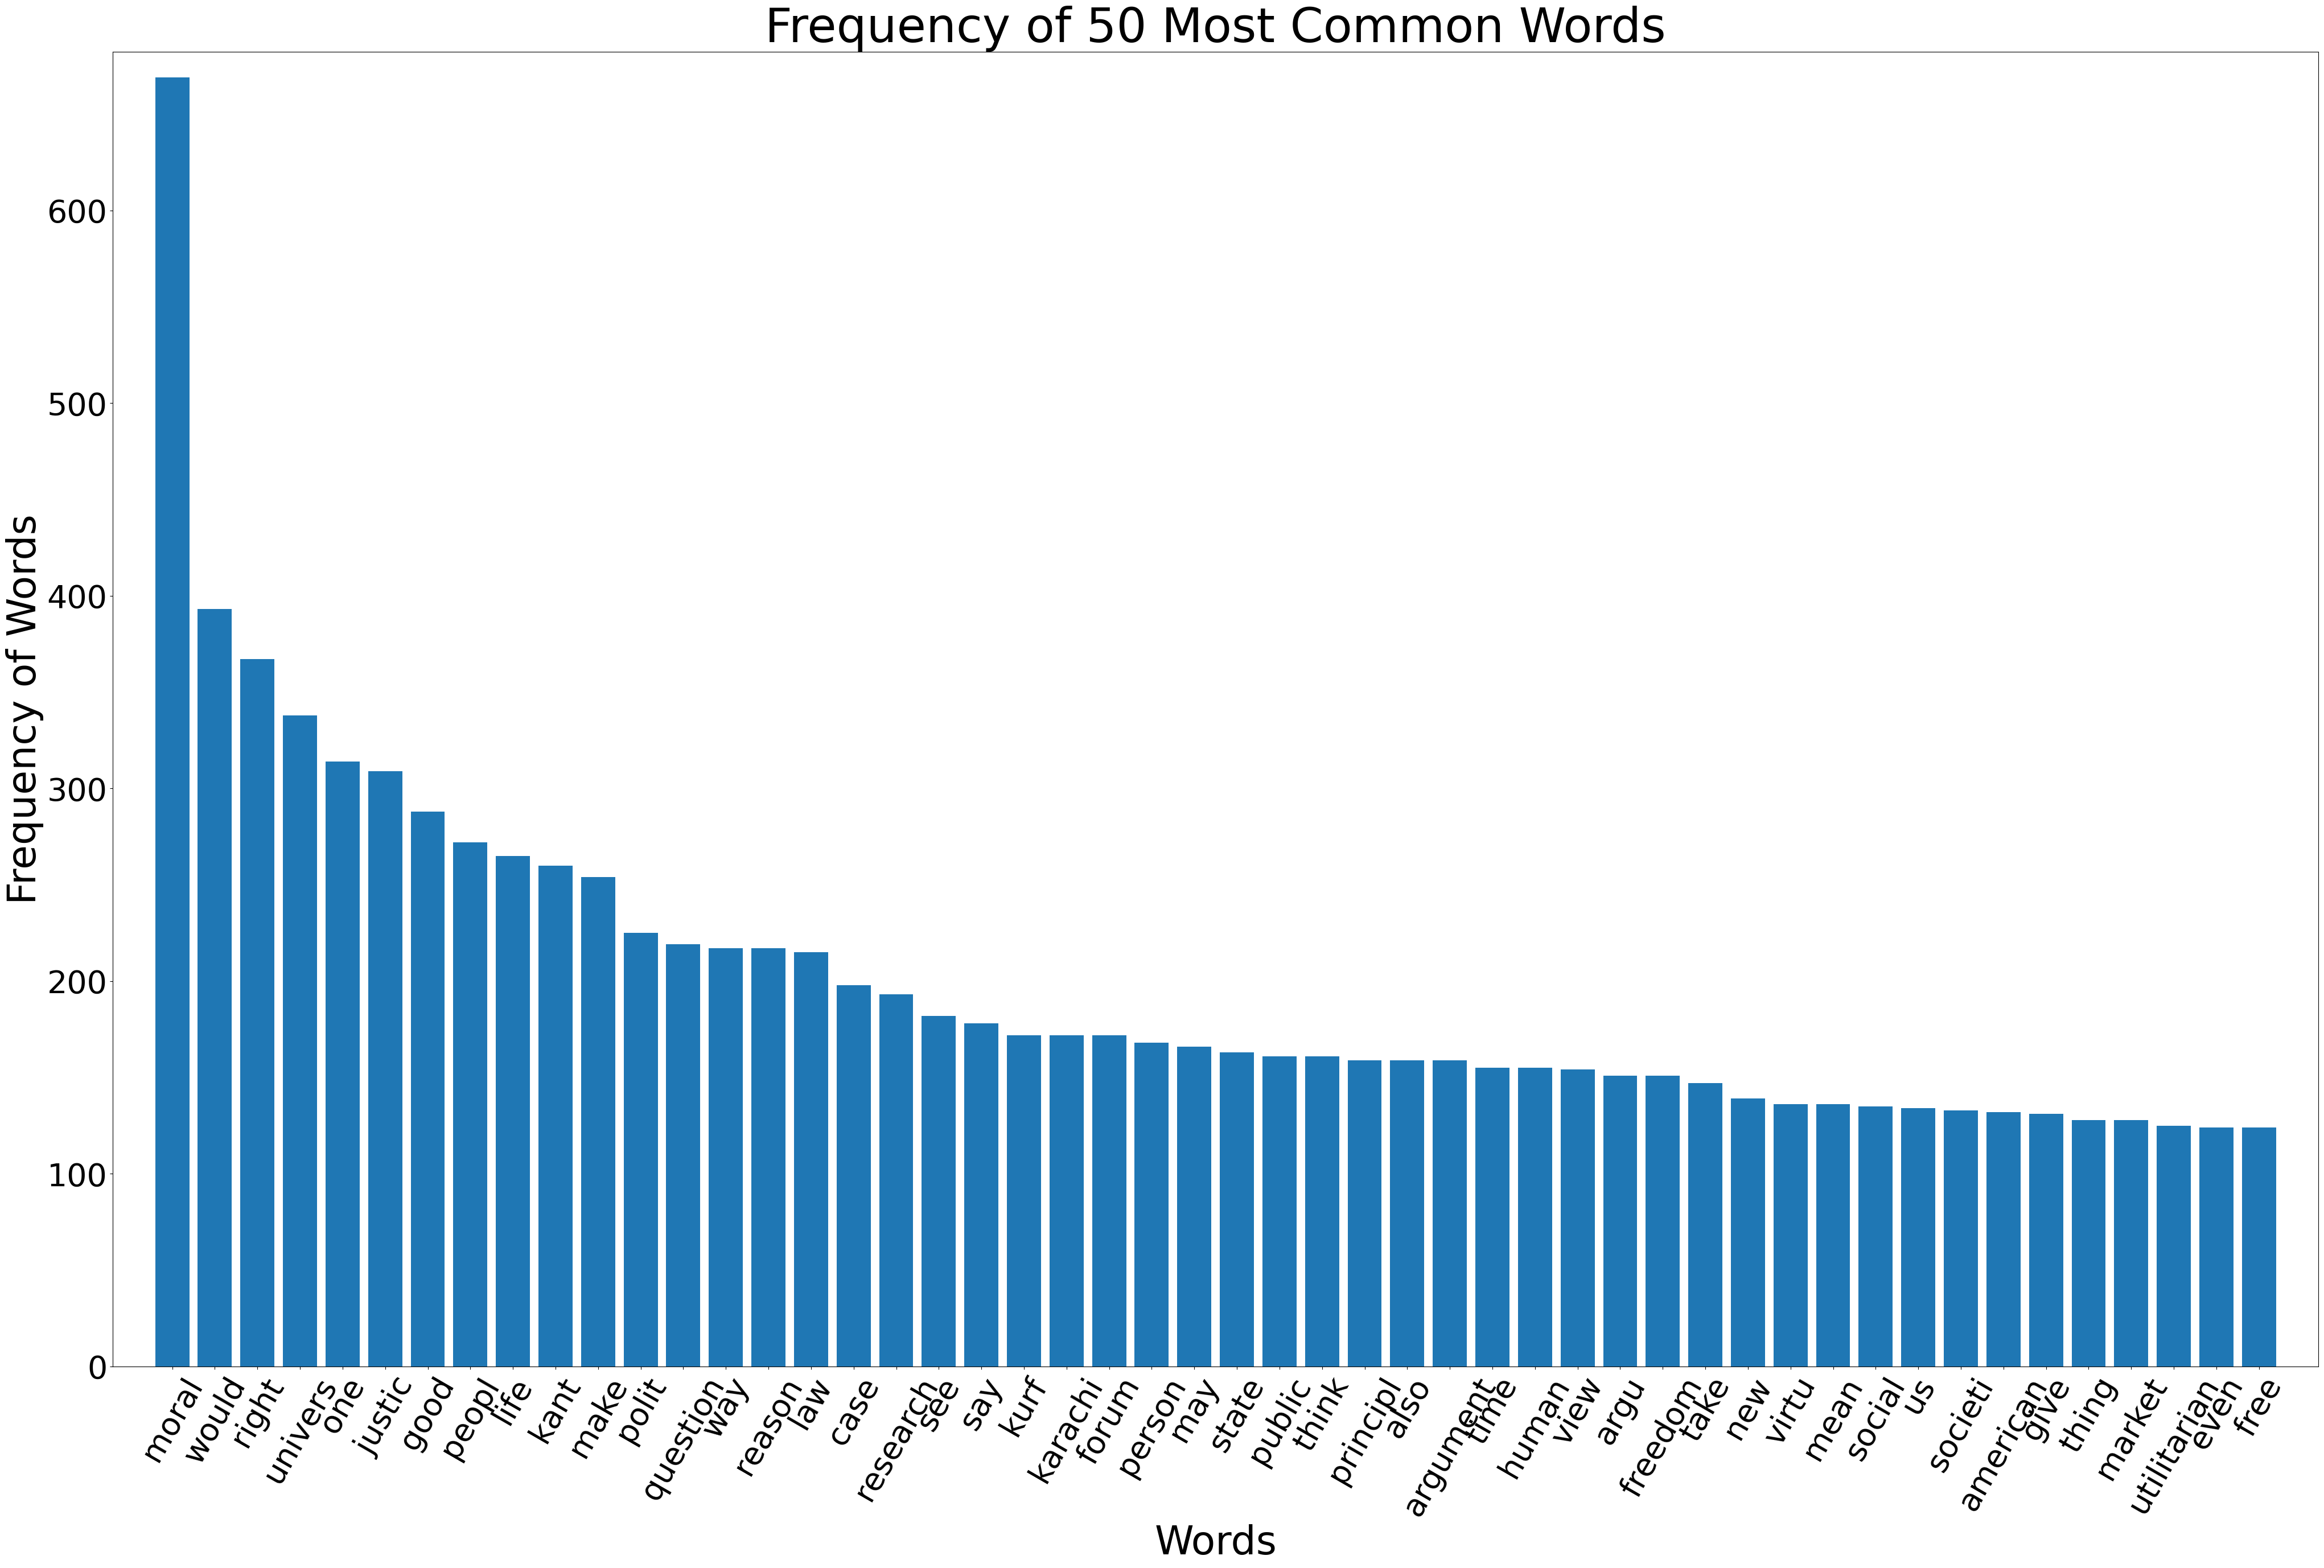

In [22]:
x, y = zip(*fdist_justice)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 50 Most Common Words', fontsize=60)
plt.show()

In [11]:
# vectorise the words
justice_dict = corpora.Dictionary(justice_stemmed)
token_to_id = justice_dict.token2id
print(type(token_to_id))
# print(token_to_id) ？

# Converting all documents in SGNews Apr2012 to a list of sparse vectors.
justice_vecs = [justice_dict.doc2bow(doc) for doc in justice_stemmed]
print(justice_vecs[-1][-1])

# compare similarity (not done)
sample_index = similarities.SparseMatrixSimilarity(justice_vecs, 5471)

<class 'dict'>
(5471, 1)
